## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-03-15 15:30:18.726215


{1: 24.0,
 5: 25.3,
 10: 26.1,
 20: 27.0,
 30: 28.3,
 40: 30.1,
 50: 31.9,
 60: 33.7,
 70: 35.7,
 80: 38.2,
 90: 41.6,
 95: 44.5,
 99: 50.0}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-03-15 12:27:41.902659


{1: 8.0,
 5: 8.2,
 10: 8.4,
 20: 8.6,
 30: 8.8,
 40: 8.9,
 50: 9.1,
 60: 9.2,
 70: 9.4,
 80: 9.6,
 90: 9.9,
 95: 10.1,
 99: 10.5}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-03-15 12:30:55.271687


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=4.04, lognorm_sd=3.21, norm_mean=1.15, norm_sd=0.7) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.015, 0.8, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)

    frac = ~gdp_frac * ~percent_spent_on_compute * ~percent_spent_on_largest_model
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19.5),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 25401.58it/s]


{1: 0.00074,
 5: 0.00106,
 10: 0.00132,
 20: 0.00172,
 30: 0.00213,
 40: 0.0026,
 50: 0.00318,
 60: 0.00393,
 70: 0.00515,
 80: 0.00782,
 90: 0.01176,
 95: 0.0145,
 99: 0.01967}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.074%',
 5: '0.106%',
 10: '0.132%',
 20: '0.172%',
 30: '0.213%',
 40: '0.26%',
 50: '0.318%',
 60: '0.393%',
 70: '0.515%',
 80: '0.782%',
 90: '1.176%',
 95: '1.45%',
 99: '1.967%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '18.8 billion',
 5: '26.7 billion',
 10: '33.2 billion',
 20: '43.2 billion',
 30: '53.4 billion',
 40: '65.3 billion',
 50: '79.6 billion',
 60: '99.0 billion',
 70: '129.4 billion',
 80: '197.0 billion',
 90: '295.4 billion',
 95: '366.8 billion',
 99: '493.3 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 343879.97it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00025,
 60: 0.00037,
 70: 0.00056,
 80: 0.00088,
 90: 0.00167,
 95: 0.00285,
 99: 0.00751}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.025%',
 40: '0.025%',
 50: '0.025%',
 60: '0.037%',
 70: '0.056%',
 80: '0.088%',
 90: '0.167%',
 95: '0.285%',
 99: '0.751%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6.2 billion',
 5: '6.2 billion',
 10: '6.3 billion',
 20: '6.3 billion',
 30: '6.3 billion',
 40: '6.3 billion',
 50: '6.4 billion',
 60: '9.4 billion',
 70: '14.1 billion',
 80: '22.2 billion',
 90: '41.9 billion',
 95: '71.5 billion',
 99: '190.6 billion'}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 3.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2024$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15.2 sextillion) per 2024$USD.
* We are initially willing to pay 8.4 log 2024$USD (~242.8 million).
* This doubles every 1.6 year to a max of 0.028872% of GDP (initially ~7.3 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 27.8 logFLOP which costs 9.4 log 2024$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 26.8 2024-log-eFLOP)
2025 - TAI takes 27.7 logFLOP which costs 9.2 log 2024$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.2 2024-log-eFLOP)
2026 - TAI takes 27.6 logFLOP which costs 8.9 log 2024$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.6 2024-log-eFLOP)
2027 - TAI takes 27.6 logFLOP which costs 8.7 lo

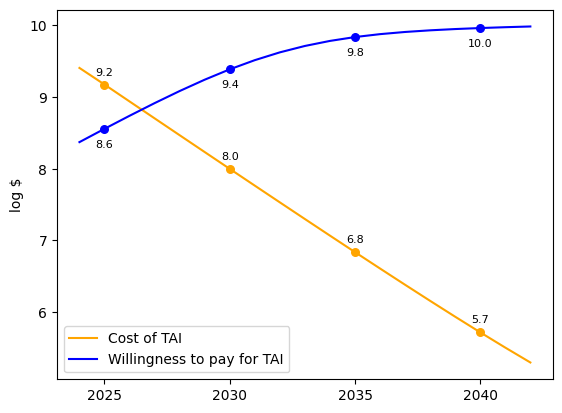



## SAMPLE RUN 2 ##

In this simulation:
* It takes 29.9 log FLOP (~794.3 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.8 quintillion) per 2024$USD.
* Every 1.8 years they get 2x cheaper, to a maximum of 20.3 log FLOP (~219.5 quintillion) per 2024$USD.
* We are initially willing to pay 9.6 log 2024$USD (~4.2 billion).
* This doubles every 13.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.019x per year.
---
2024 - TAI takes 29.9 logFLOP which costs 11.5 log 2024$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 27.9 2024-log-eFLOP)
2025 - TAI takes 29.7 logFLOP which costs 11.1 log 2024$USD to buy vs. WTP at 9.4 (buys 28.0 log FLOP or 28.2 2024-log-eFLOP)
2026 - TAI takes 29.5 logFLOP which costs 10.7 log 2024$USD to buy vs. WTP at 9.4 (buys 28.2 log FLOP or 28.6 2024-log-eFLOP)
2027 - TAI takes 29.3 logFLOP which costs 10.

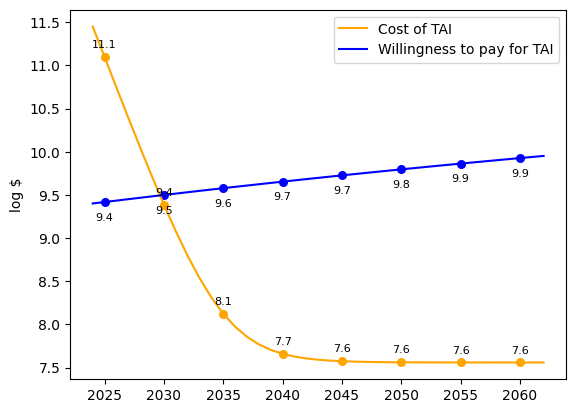



## SAMPLE RUN 3 ##

In this simulation:
* It takes 34.4 log FLOP (~25.1 decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~59.4 septillion) per 2024$USD.
* We are initially willing to pay 9.5 log 2024$USD (~3.0 billion).
* This doubles every 10.3 year to a max of 0.046613% of GDP (initially ~11.7 billion 2024$USD).
* GDP grows at a rate of 1.033x per year.
---
2024 - TAI takes 34.4 logFLOP which costs 16.3 log 2024$USD to buy vs. WTP at 9.4 (buys 27.5 log FLOP or 27.5 2024-log-eFLOP)
2025 - TAI takes 34.2 logFLOP which costs 16.0 log 2024$USD to buy vs. WTP at 9.4 (buys 27.6 log FLOP or 27.8 2024-log-eFLOP)
2026 - TAI takes 34.0 logFLOP which costs 15.6 log 2024$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 28.2 2024-log-eFLOP)
2027 - TAI takes 33.7 logFLOP which costs 15

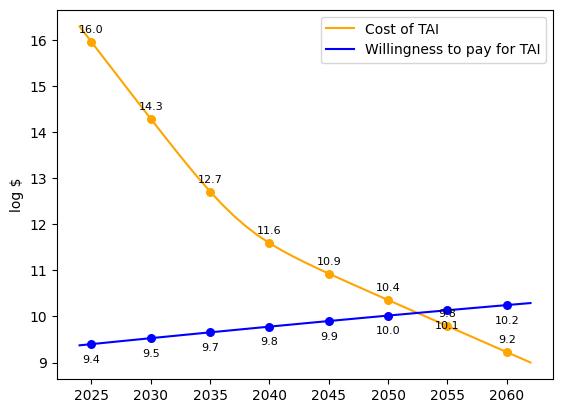



## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


 48%|████████████████████████████                               | 4750/10000 [00:32<00:29, 179.33it/s]

In [ ]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


In [ ]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [ ]:
print('File last ran: {}'.format(dt.now()))